# Application of Fourier Flows to Synthetic Data

In this notebook, we reproduce the first experiment (Section 5.1) in our paper "Generative Time-series Modeling with Fourier Flows" published in ICLR 2021 by Ahmed M. Alaa, Alex Chan and Mihaela van der Schaar. 

In [1]:
from data.synthetic import *
from utils.spectral import *
from SequentialFlows import *
from models.sequential import *
from timegan import timegan

import numpy as np
import pickle

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

### Sampling synthetic data

Here we consider the following time-series data generation process:

$x = \sin(ft + \phi),$ $\phi \sim \mathcal{N}(0,1)$, $f \sim Beta(\alpha, \beta), t \in \{0, \ldots, T-1\}$

In [2]:
T           = 101
n_samples   = 1000
X           = sine_data_generation(no=n_samples, seq_len=T, dim=1)

### Fitting the Fourier Flows and Real-NVP models

Imported from "SequentialFlows"

In [19]:
FF_model    = FourierFlow(hidden=200, fft_size=T, n_flows=10, normalize=False) #True)  
RVP_model   = RealNVP(hidden=200, T=T, n_flows=10) 

In [20]:
FF_losses   = FF_model.fit(X, epochs=1000, batch_size=128, 
                           learning_rate=1e-3, display_step=100)

step: 0 	/ 1000 	----------	loss: 128.587
step: 100 	/ 1000 	|---------	loss: -395.410
step: 200 	/ 1000 	||--------	loss: -470.093
step: 300 	/ 1000 	|||-------	loss: -509.706
step: 400 	/ 1000 	||||------	loss: -542.338
step: 500 	/ 1000 	|||||-----	loss: -550.214
step: 600 	/ 1000 	||||||----	loss: -585.527
step: 700 	/ 1000 	|||||||---	loss: -606.603
step: 800 	/ 1000 	||||||||--	loss: -628.878
step: 900 	/ 1000 	|||||||||-	loss: -599.929
step: 999 	/ 1000 	||||||||||	loss: -645.286
Finished training!


In [5]:
RVP_losses  = RVP_model.fit(X, epochs=1000, batch_size=128, 
                            learning_rate=1e-3, display_step=100)

step: 0 	/ 1000 	----------	loss: 207.504
step: 100 	/ 1000 	|---------	loss: 101.423
step: 200 	/ 1000 	||--------	loss: 86.130
step: 300 	/ 1000 	|||-------	loss: 50.426
step: 400 	/ 1000 	||||------	loss: 20.380
step: 500 	/ 1000 	|||||-----	loss: 4.849
step: 600 	/ 1000 	||||||----	loss: -15.008
step: 700 	/ 1000 	|||||||---	loss: -45.694
step: 800 	/ 1000 	||||||||--	loss: -47.368
step: 900 	/ 1000 	|||||||||-	loss: -61.972
step: 999 	/ 1000 	||||||||||	loss: -73.614
Finished training!


### Sample from Fourier flows and Real-NVP models

In [21]:
X_gen_FF   = FF_model.sample(1000)
X_gen_RVP  = RVP_model.sample(1000)

### Fitting and sampling from TimeGAN model

In [7]:
X_                   = [X[k].reshape((-1, 1)) for k in range(len(X))]
X_gen_TGAN           = timegan(X_, dict({'module': 'gru', 'hidden_dim': 24, 'num_layer': 3, 
                                         'iterations': 500, 'batch_size': 128})) 

Start Embedding Network Training
step: 0/500, e_loss: 0.369
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/500, s_loss: 0.256
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/500, d_loss: 2.2176, g_loss_u: 0.5465, g_loss_s: 0.0448, g_loss_v: 0.5218, e_loss_t0: 0.333
Finish Joint Training


### Fitting predictive RNN models

We evaluate the accuracy of the sampled data in the time-domain by assessing their predictive usefulness as follows: we trained a vanilla RNN model using each of the three synthetically generated samples to sequentially predict the next value in each time series in the original data. We then evaluate the MAE of the three RNN models across all time steps.

#### Instantiate RNN models and prepare labeled sequential data

In [22]:
predictive_model_TGAN    = RNNmodel(HIDDEN_UNITS=100, NUM_LAYERS=2, MAX_STEPS=100, INPUT_SIZE=1)
predictive_model_RealNVP = RNNmodel(HIDDEN_UNITS=100, NUM_LAYERS=2, MAX_STEPS=100, INPUT_SIZE=1)
predictive_model_FF      = RNNmodel(HIDDEN_UNITS=100, NUM_LAYERS=2, MAX_STEPS=100, INPUT_SIZE=1)

X_FF                     = [X_gen_FF[k][:len(X_gen_FF[k])-1] for k in range(len(X_gen_FF))]
Y_FF                     = [X_gen_FF[k][1:] for k in range(len(X_gen_FF))]

X_RealNVP                = [X_gen_RVP [k][:len(X_gen_RVP [k])-1] for k in range(len(X_gen_RVP ))]
Y_RealNVP                = [X_gen_RVP [k][1:] for k in range(len(X_gen_RVP ))]

X_TGAN                   = [X_gen_TGAN[k][:len(X_gen_TGAN[k])-1] for k in range(len(X_gen_TGAN))]
Y_TGAN                   = [X_gen_TGAN[k][1:] for k in range(len(X_gen_TGAN))]

#### Fit the three RNN models, each on a synthetic data set generated by a different baseline

In [23]:
predictive_model_FF.fit(X_FF, Y_FF)
predictive_model_RealNVP.fit(X_RealNVP, Y_RealNVP)
predictive_model_TGAN.fit(X_TGAN, Y_TGAN)

Epoch:  0 | train loss: 0.8177
Epoch:  1 | train loss: 0.0598
Epoch:  2 | train loss: 0.0177
Epoch:  3 | train loss: 0.0292
Epoch:  4 | train loss: 0.0130


### Visualizing the results

#### Reconstruction of Figure 2(a). 

The three figures below demonstrate the spectral components of a sample from each of the three models. Each sample will have a slightly different spectrum at each run. On average, the TimeGAN model tends to "memorize" the real data. This manifest in the support of the estimated spectral density in one of two ways. The model either concentrates the probability mass on the frequency components observed in the real data (as in the sample illustrated in the paper), or covers a wider support including higher and lower frequencies than the ones observed based on outliers in the data.

<AxesSubplot:>

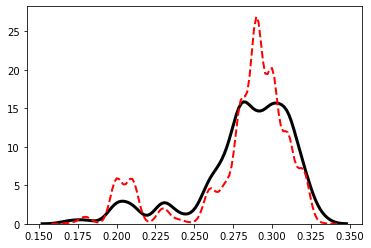

In [24]:
sns.distplot(get_frequencies(X), hist=False, color="black", kde_kws={'linewidth':3})
sns.distplot(get_frequencies(X_gen_FF), hist=False, color="red", kde_kws={'linestyle':'--', 'linewidth':2})

<AxesSubplot:>

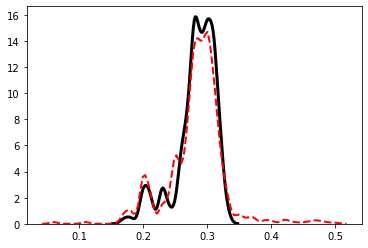

In [25]:
sns.distplot(get_frequencies(X), hist=False, color="black", kde_kws={'linewidth':3})
sns.distplot(get_frequencies(X_gen_RVP), hist=False, color="red", kde_kws={'linestyle':'--', 'linewidth':2})

<AxesSubplot:>

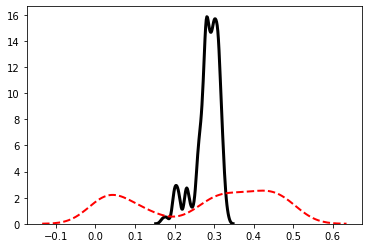

In [26]:
sns.distplot(get_frequencies(X), hist=False, color="black", kde_kws={'linewidth':3})
sns.distplot(get_frequencies(X_gen_TGAN), hist=False, color="red", kde_kws={'linestyle':'--', 'linewidth':2})

#### Reconstruction of Figure 2(b). 

Learning curves, accuracy of the recovered spectra and accuracy of RNN models trained on synthetic data. 

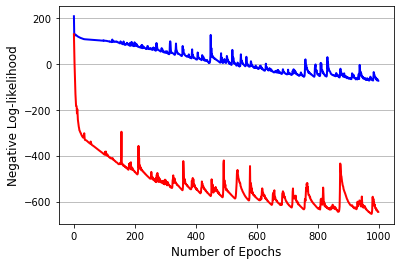

In [27]:
plt.plot(RVP_losses, linewidth=2, color="b")
plt.plot(FF_losses, linewidth=2, color="r")

plt.xlabel("Number of Epochs", fontsize=12)
plt.ylabel("Negative Log-likelihood", fontsize=12)

plt.grid(axis="y")

In [28]:
FF_PSD_Errors      = np.abs(power_spectral_density(X)-power_spectral_density(X_gen_FF))[:100]
RealNVP_PSD_Errors = np.abs(power_spectral_density(X)-power_spectral_density(X_gen_RVP))[:100]
TGAN_PSD_Errors    = np.abs(power_spectral_density(X)-power_spectral_density(X_gen_TGAN.reshape((1000, 101))))[:100]

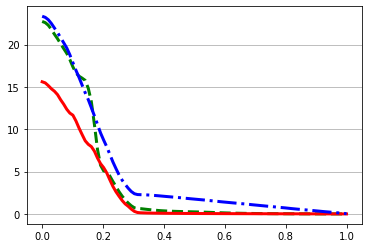

In [29]:
freqs              = np.linspace(0, 1, 100)

plt.plot(freqs, np.cumsum(TGAN_PSD_Errors)[::-1], linewidth=3, color="g", linestyle="--")
plt.plot(freqs, np.cumsum(FF_PSD_Errors)[::-1], linewidth=3, color="r")
plt.plot(freqs, np.cumsum(RealNVP_PSD_Errors)[::-1], linewidth=3, color="b", linestyle="-.")

plt.grid(axis="y")

In [30]:
X_true                  = [X[k][:len(X[k])-1] for k in range(len(X))]
Y_true                  = [X[k][1:] for k in range(len(X))]

X_TGAN_pred             = predictive_model_TGAN.predict(X_true)
X_FF_pred               = predictive_model_FF.predict(X_true)
X_RealNVP_pred          = predictive_model_RealNVP.predict(X_true)

In [31]:
TGAN_RNN_errs    = np.mean(np.abs(np.array(X_TGAN_pred) - np.array(Y_true)), axis=0)
FF_RNN_errs      = np.mean(np.abs(np.array(X_FF_pred) - np.array(Y_true)), axis=0)
RealNVP_RNN_errs = np.mean(np.abs(np.array(X_RealNVP_pred) - np.array(Y_true)), axis=0)

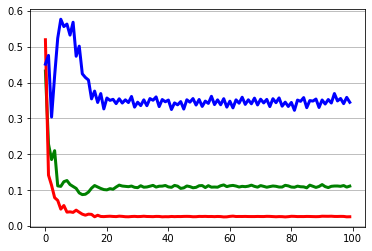

In [32]:
plt.plot(TGAN_RNN_errs, linewidth=3, color="g")
plt.plot(FF_RNN_errs, linewidth=3, color="r")
plt.plot(RealNVP_RNN_errs, linewidth=3, color="b")

plt.grid(axis="y")